In [1]:
import pandas as pd
import os
import pickle
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from conf_ensemble import ConfEnsembleLibrary
from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ccdc_rdkit_connector import CcdcRdkitConnector

In [2]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [3]:
data_dir_path = 'data/'

# Extract PDBBind conformations

In [4]:
pdbbind_refined_dir_path = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir_path = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [5]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(os.path.join(pdbbind_refined_dir_path, 'index', 'INDEX_general_PL_data.2020'), widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [6]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG)
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX)
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3)
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP)
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM)


In [7]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [8]:
pl_data.shape

(16844, 7)

In [9]:
correct_pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [10]:
def extract_pdbbind_mols(directory_path, query_pdb_ids) :
    mols = []
    pdb_ids = [pdb_id for pdb_id in os.listdir(directory_path) if pdb_id in query_pdb_ids]
    for pdb_id in pdb_ids :
        mol2path = os.path.join(directory_path, pdb_id, f'{pdb_id}_ligand.mol2')
        try :
            mol = Chem.rdmolfiles.MolFromMol2File(mol2path)
            if mol is not None :
                rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
                if rdmol is not None : #rdkit parsable
                    #mol = PropertyMol(mol)
                    mol.GetConformer().SetProp('PDB_ID', pdb_id)
                    mols.append(mol)
                else :
                    print('Not RDKit parsable')
        except :
            print('Impossible to read mol2 file for ' + pdb_id)
            
    return mols

In [11]:
general_mols = extract_pdbbind_mols(pdbbind_general_dir_path, correct_pdb_ids)
print(len(general_mols))

RDKit WARNING: [12:58:09] 3b5j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:09] 3b5j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:09] 6cve_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:09] 6cve_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:09] 5jc1_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:09] 6n53_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:09] 2o4h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:09] 5jc1_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:09] 6n53_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:09] 2o4h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit ERROR: [12:58:09] Explicit valence for atom # 9 C, 5, is greater than permitted
[12:58:09] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit WARNING: [12:58:09] sanitise [12:58:09] 1a7x_ligan

Not RDKit parsable


RDKit WARNING: [12:58:13] 4ozn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 5a7j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 3kc0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 1lol_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 4ozn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 5vjn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 3dgn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 5a7j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 3kc0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 1lol_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 5vjn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:13] 3dgn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:13] 1i41_ligand: warning - O.co2 wit

Not RDKit parsable


RDKit ERROR: [12:58:14] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit ERROR: 
RDKit WARNING: [12:58:14] sanitise [12:58:14] 5lwe_ligand: [12:58:14] 1ch8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:14] 5km0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 1tmm_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 6f3f_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 4na4_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] Can't kekulize mol.  Unkekulized atoms: 9 10 27 30 32

[12:58:14] sanitise [12:58:14] 5wjj_ligand: [12:58:14] 5klp_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 5g1n_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 4dpt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:14] 1c7e_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:14] 1bo5_ligand: warning - O.co2 with non C.2 or S.o2 neighbor

Not RDKit parsable


RDKit WARNING: [12:58:16] 3rl4_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:16] 6cer_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:16] 3dkj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 3wc7_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 3rl4_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 6cer_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 3dkj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:16] 3gqo_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 3gqo_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:16] 5ygi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 5ygi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:16] 6g22_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:16] 6g22_ligand: warning - O.co2 with non C.2 or S.

Not RDKit parsable


RDKit WARNING: [12:58:17] 4mdt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 4umj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 4mdt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 4umj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 1oth_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 6eji_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 3pjt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 2o1v_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 1oth_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 6eji_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 3pjt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 2o1v_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 5w19_ligand: warning - O.co2 wit

10635


RDKit WARNING: [12:58:17] 3ump_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 3ump_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 5myd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 5o0j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 5myd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 3iuc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 5o0j_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 3iuc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:17] 3ffu_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:18] 1me7_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:18] 3rbm_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:17] 3ffu_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:18] 1me7_ligand: warning - O.co2 wit

In [12]:
refined_mols = extract_pdbbind_mols(pdbbind_refined_dir_path, correct_pdb_ids)
print(len(refined_mols))

RDKit WARNING: [12:58:19] 5dus_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 5dus_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 3qx9_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 3qx9_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 4kxn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 4kxn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 1qhc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 6fhk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 1qhc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 6fhk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 5btx_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:19] 5btx_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:19] 2zz2_ligand: warning - O.co2 wit

4400


RDKit WARNING: [12:58:22] 5cst_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 1o0h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 1yei_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 3hu3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 5cst_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 1o0h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 1yei_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 3hu3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 2haw_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 2haw_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 1o0f_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:58:22] 1ols_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:58:22] 1o0f_ligand: warning - O.co2 wit

In [13]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list.p'), 'wb') as f :
    pickle.dump(general_mols, f)

In [14]:
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list.p'), 'wb') as f :
    pickle.dump(refined_mols, f)

In [15]:
general_CEL = ConfEnsembleLibrary(general_mols)
refined_CEL = ConfEnsembleLibrary(refined_mols)

100%|█████████████████████████████████████| 4400/4400 [00:02<00:00, 2144.50it/s]


In [16]:
pdbbind_CEL = general_CEL.merge(refined_CEL)

In [17]:
os.makedirs(os.path.join(data_dir_path, 'raw'), exist_ok=True)

In [18]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(general_CEL, f)

In [19]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_refined_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(refined_CEL, f)

In [20]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(pdbbind_CEL, f)

# Extract Platinum conformations

In [21]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [22]:
len(platinum_mols)

4548

In [23]:
# Add PDB_ID information to conformer
with open(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf')) as f :
    lines = f.readlines()
    lines = [line.strip() for line in lines]

pdb_ids = []
new_mol = True
for line in lines :
    if new_mol :
        pdb_ids.append(line)
        new_mol = False
    if line == '$$$$' :
        new_mol = True
        
for i, mol in enumerate(tqdm(platinum_mols)) :
    mol.GetConformer().SetProp('PDB_ID', pdb_ids[i])

100%|███████████████████████████████████| 4548/4548 [00:00<00:00, 711434.55it/s]


In [24]:
platinum_CEL = ConfEnsembleLibrary(platinum_mols)

100%|█████████████████████████████████████| 4548/4548 [00:01<00:00, 2437.45it/s]


In [25]:
with open(os.path.join(data_dir_path, 'raw', 'platinum_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(platinum_CEL, f)

# Join PDBBind and Platinum, and compare the 2 datasets

In [26]:
all_CEL = pdbbind_CEL.merge(platinum_CEL)

In [27]:
with open(os.path.join(data_dir_path, 'raw', 'all_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(all_CEL, f)

In [30]:
all_CEL.get_num_molecules()

15949

In [31]:
all_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules()]
pdbbind_smiles = [smiles for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_smiles = [smiles for smiles, ce in platinum_CEL.get_unique_molecules()]

In [32]:
len(pdbbind_smiles)

12349

In [33]:
len(platinum_smiles)

4548

In [34]:
smiles_df = pd.DataFrame(all_smiles, columns=['smiles'])

In [35]:
smiles_df['pdbbind'] = smiles_df['smiles'].isin(pdbbind_smiles)
smiles_df['platinum'] = smiles_df['smiles'].isin(platinum_smiles)

In [36]:
pdbbind_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in platinum_CEL.get_unique_molecules()]

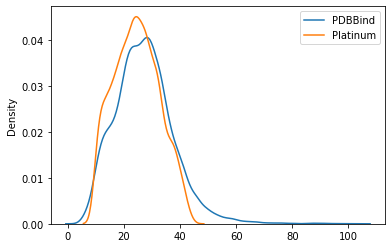

In [37]:
sns.kdeplot(pdbbind_n_heavy_atoms, label='PDBBind')
sns.kdeplot(platinum_n_heavy_atoms, label='Platinum')
plt.legend()
plt.show()

In [38]:
# For computational (conformation generation) and dataset matching reasons,
# PDBBind molecules having more than 50 heavy atoms were excluded

In [39]:
included_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules() if ce.mol.GetNumHeavyAtoms() <= 50]
smiles_df['included'] = smiles_df['smiles'].isin(included_smiles)

In [40]:
len(included_smiles)

15666

In [41]:
smiles_df.to_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [42]:
ccdc_rdkit_connector = CcdcRdkitConnector()

In [43]:
initial_ccdc_mols = []
corresponding_ce_mols = []
for smiles, conf_ensemble in tqdm(all_CEL.get_unique_molecules()) :
    if smiles in included_smiles : # see comments above
        ccdc_mol = ccdc_rdkit_connector.rdkit_conf_to_ccdc_mol(conf_ensemble.mol)
        assert conf_ensemble.mol.GetNumAtoms() == len(ccdc_mol.atoms)
        initial_ccdc_mols.append(ccdc_mol)
        corresponding_ce_mols.append(conf_ensemble.mol)

100%|███████████████████████████████████| 15949/15949 [00:05<00:00, 3090.87it/s]


In [44]:
n_conf_per_chunk = 100
chunk_idxs = [list(range(i, i + n_conf_per_chunk)) for i in range(0, len(initial_ccdc_mols), n_conf_per_chunk)]

In [45]:
len(initial_ccdc_mols)

15666

In [48]:
ccdc_conformer_generator = ConformerGenerator(nthreads=8)
ccdc_conformer_generator.settings.max_conformers = 100

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


In [ ]:
for chunk_idx in tqdm(chunk_idxs) :
    
    mol_list = [mol for i, mol in enumerate(initial_ccdc_mols) if i in chunk_idx]
    ce_mols = [mol for i, mol in enumerate(corresponding_ce_mols) if i in chunk_idx]
    
    conformers = ccdc_conformer_generator.generate(mol_list)
    
    for ce_mol, conformers in zip(ce_mols, conformers) :
        try :
            generated_conf_ids = ccdc_rdkit_connector.ccdc_conformers_to_rdkit_mol(conformers, ce_mol)
        except Exception as e :
            print(e)

  0%|                                                   | 0/157 [00:00<?, ?it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  1%|▎                                        | 1/157 [00:33<1:26:50, 33.40s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  1%|▌                                        | 2/157 [01:02<1:19:27, 30.76s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  2%|▊                                        | 3/157 [01:32<1:18:29, 30.58s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  3%|█                                        | 4/157 [01:57<1:11:42, 28.12s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  3%|█▎                                       | 5/157 [02:26<1:12:23, 28.57s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  4%|█▌                                       | 6/157 [03:12<1:27:08, 34.62s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  4%|█▊                                       | 7/157 [04:04<1:40:54, 40.37s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  5%|██                                       | 8/157 [04:38<1:34:46, 38.17s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  6%|██▎                                      | 9/157 [05:21<1:37:38, 39.59s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  6%|██▌                                     | 10/157 [05:55<1:32:57, 37.94s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  7%|██▊                                     | 11/157 [06:33<1:32:35, 38.05s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  8%|███                                     | 12/157 [09:40<3:21:15, 83.28s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  8%|███▎                                    | 13/157 [10:25<2:51:54, 71.63s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


  9%|███▌                                    | 14/157 [10:57<2:22:35, 59.83s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 10%|███▊                                    | 15/157 [11:28<2:00:46, 51.03s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 10%|████                                    | 16/157 [12:00<1:46:45, 45.43s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 11%|████▎                                   | 17/157 [12:56<1:53:17, 48.56s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 11%|████▌                                   | 18/157 [13:30<1:42:04, 44.06s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 12%|████▊                                   | 19/157 [16:49<3:28:27, 90.64s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 13%|█████                                   | 20/157 [17:22<2:47:30, 73.36s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 13%|█████▎                                  | 21/157 [18:07<2:26:53, 64.80s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 14%|█████▌                                  | 22/157 [18:37<2:02:36, 54.49s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 15%|█████▊                                  | 23/157 [19:27<1:58:46, 53.18s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 15%|██████                                  | 24/157 [20:01<1:44:42, 47.23s/it]

In [ ]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library_unfiltered.p'), 'wb') as f :
    pickle.dump(all_CEL, f)
    
# here we only have the molecules parsed identically by RDKit (from mol2) and CSD (from smiles)

In [ ]:
faulty_smiles = ['O=C[Ru+9]12345(C6=C1C2C3=C64)n1c2ccc(O)cc2c2c3c(c4ccc[n+]5c4c21)C(=O)NC3=O',
 'Cc1cc2c3c(c4c5ccccc5n5c4c2[n+](c1)[Ru+9]51246(Cl)C5=C(C(=O)[O-])C1=C2C4=C56)C(=O)NC3=O']
# cannot be pickled because of a number of radical electron error

In [ ]:
smiles_df.loc[smiles_df['smiles'].isin(faulty_smiles), 'included'] = False

In [ ]:
smiles_df.to_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [ ]:
excluded_smiles = smiles_df[~smiles_df['included']]['smiles'].values

In [ ]:
len(excluded_smiles)

In [ ]:
for smiles in excluded_smiles :
    all_CEL.library.pop(smiles)

In [ ]:
all_CEL.get_num_molecules()

In [ ]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(all_CEL, f)

# Generate conf table for data file creation torch geometric

In [6]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    all_CEL = pickle.load(f)

In [7]:
smiles_df = pd.read_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [11]:
conf_list = []
for smiles in smiles_df[smiles_df['included']]['smiles'].values :
    confs = all_CEL.get_conf_ensemble(smiles).mol.GetConformers()
    for conf in confs :
        generated = 'Generator' in conf.GetPropsAsDict()
        conf_list.append([smiles, generated])

In [12]:
len(conf_list)

1165920

In [13]:
conf_df = pd.DataFrame(conf_list, columns=['smiles', 'generated'])

In [15]:
conf_df.to_csv(os.path.join(data_dir_path, 'conf_df.csv'))